# **２．Newmark-β法による地震応答の数値解析の精度と安定性（無条件安定）**

## **2.1　$\Delta t/T_n$ = 0.05（時間刻み幅が短い場合）**

In [2]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 42.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a6bd8f5722d2e97216cc9c6b87f78946876721db662654caf8164bee069dbe34
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


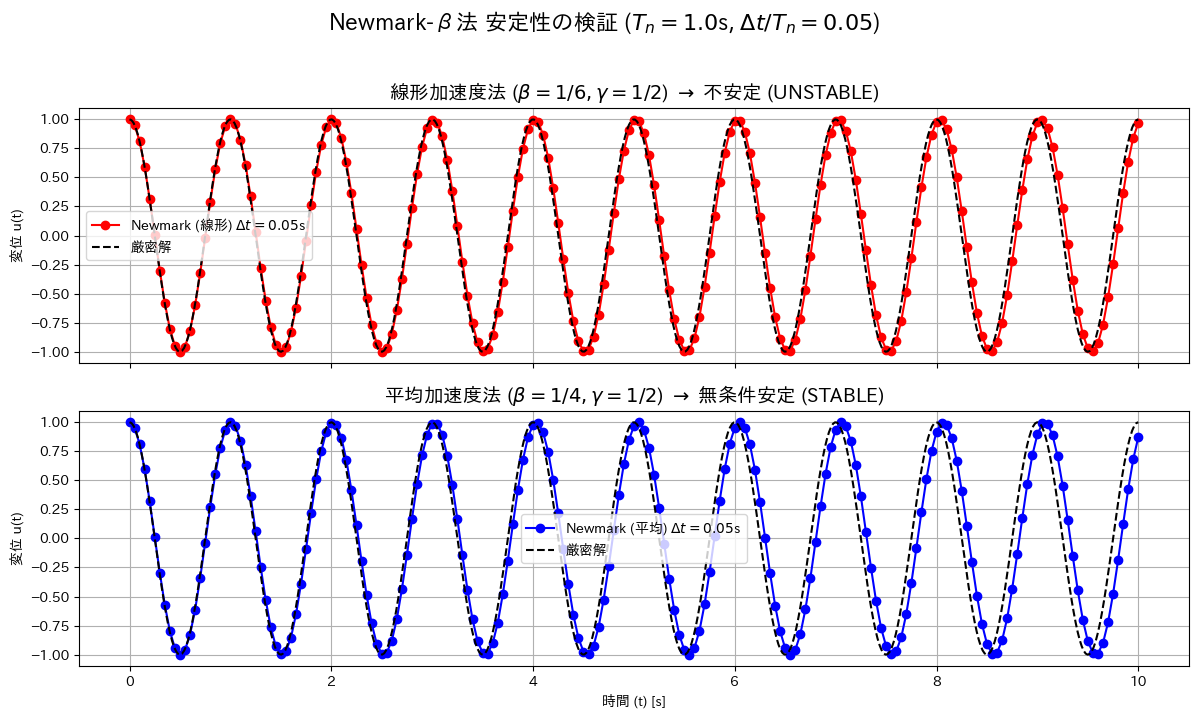

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    """
    Newmark-β法（有効剛性法）の汎用ソルバー

    引数:
    m, c, k : 質量, 減衰, 剛性
    p_force : 外力P(t)の時系列配列
    dt : 時間ステップ Δt
    u0, v0 : 初期変位, 初期速度
    beta, gamma : Newmark-β法のパラメータ

    戻り値:
    t : 時間配列
    u, v, a : 変位, 速度, 加速度の時系列配列
    """

    # ステップ数を計算
    n_steps = len(p_force)

    # 結果を格納する配列を初期化
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    # 初期条件を設定
    u[0] = u0
    v[0] = v0

    # 初期加速度を運動方程式から計算
    if m == 0:
        a[0] = 0
    else:
        a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    # --- Newmark-β法の「有効剛性法」のための係数 ---
    # .docx資料にあった係数
    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    # 有効剛性 K^ (K_hat) を計算
    K_hat = k + a0 * m + a1 * c

    # --- ステップごとの逐次計算ループ ---
    for i in range(n_steps - 1):

        # 有効外力 P^ (P_hat) を計算
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        # (1) u[i+1] を解く
        u[i+1] = P_hat / K_hat

        # (2) a[i+1] を計算
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]

        # (3) v[i+1] を計算
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    # 時間配列を作成
    t = np.arange(0, n_steps * dt, dt)

    return t, u, v, a

# -----------------------------------------------------------------
# 安定性の検証シミュレーション
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- 1. システムのパラメータ設定 ---
    # 固有周期 T_n = 1.0秒 となるように設定
    Tn = 1.0
    wn = 2.0 * np.pi / Tn
    m = 1.0
    k = wn**2 * m
    h = 0.0  # 安定性を見るため減衰ゼロ(h=0)にする
    c = 2.0 * h * wn * m

    # --- 2. 安定限界を超える時間ステップの設定 ---
    # 線形加速度法 (β=1/6) の安定限界は Δt/T_n <= 0.551
    # ここでは、限界を「超える」ように Δt/T_n = 0.6 を設定
    dt = 0.05 * Tn

    # シミュレーション時間
    t_end = 10.0  # 10秒間
    n_steps = int(t_end / dt) + 1

    # 外力 (自由振動なので全てゼロ)
    p_force = np.zeros(n_steps)

    # 初期条件 (t=0で変位1を与えて手を離す)
    u0 = 1.0
    v0 = 0.0

    # --- 3. ケース1: 線形加速度法 (不安定になるはず) ---
    beta_lin = 1.0 / 6.0
    gamma_lin = 1.0 / 2.0
    t1, u1, v1, a1 = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_lin, gamma_lin)

    # --- 4. ケース2: 平均加速度法 (安定なはず) ---
    beta_avg = 1.0 / 4.0
    gamma_avg = 1.0 / 2.0
    t2, u2, v2, a2 = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_avg, gamma_avg)

    # --- 5. 比較用の厳密解 ---
    t_exact = np.linspace(0, t_end, 500)
    u_exact = u0 * np.cos(wn * t_exact) + (v0 / wn) * np.sin(wn * t_exact)

    # --- 6. グラフ描画 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # グラフ1: 線形加速度法
    ax1.plot(t1, u1, 'r-o', label=f'Newmark (線形) $\\Delta t = {dt}$s')
    ax1.plot(t_exact, u_exact, 'k--', label='厳密解')
    ax1.set_title(f'線形加速度法 ($\\beta=1/6, \\gamma=1/2$) $\\to$ 不安定 (UNSTABLE)', fontsize=14)
    ax1.set_ylabel('変位 u(t)')
    ax1.legend()
    ax1.grid(True)

    # グラフ2: 平均加速度法
    ax2.plot(t2, u2, 'b-o', label=f'Newmark (平均) $\\Delta t = {dt}$s')
    ax2.plot(t_exact, u_exact, 'k--', label='厳密解')
    ax2.set_title(f'平均加速度法 ($\\beta=1/4, \\gamma=1/2$) $\\to$ 無条件安定 (STABLE)', fontsize=14)
    ax2.set_xlabel('時間 (t) [s]')
    ax2.set_ylabel('変位 u(t)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(f'Newmark-β法 安定性の検証 ($T_n={Tn}$s, $\\Delta t/T_n = {dt/Tn}$)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

## **2.2　$\Delta t/T_n$ = 0.2（時間刻み幅が粗い場合）**

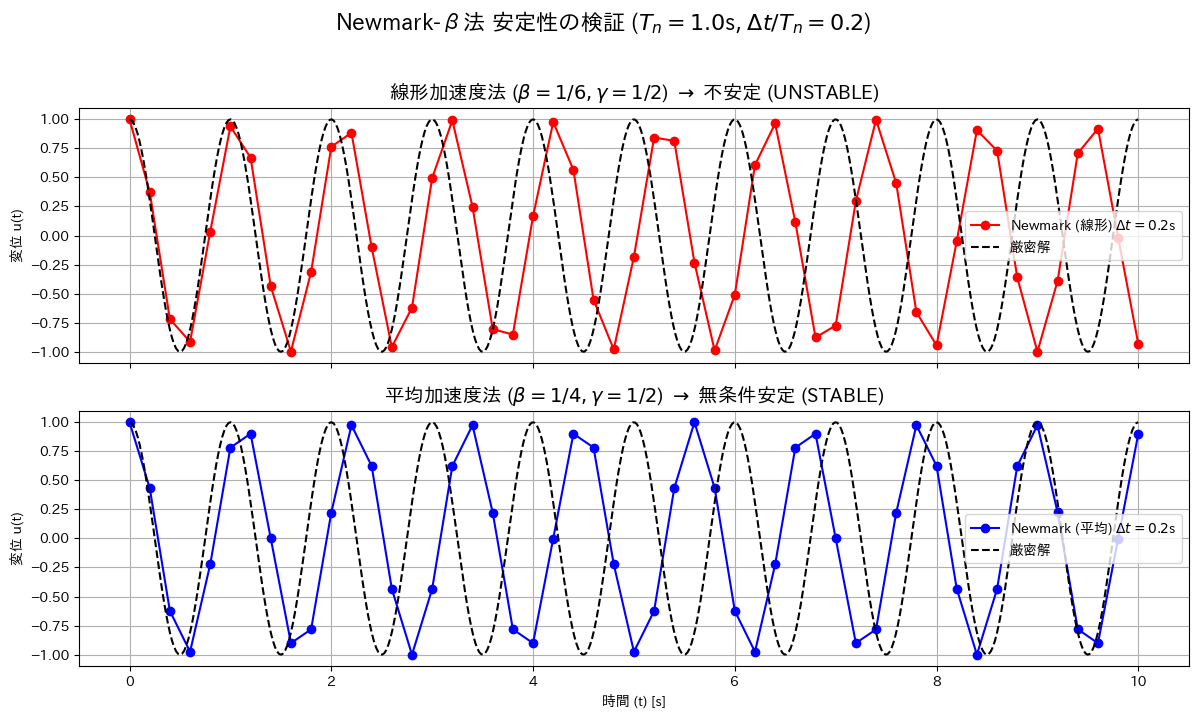

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    """
    Newmark-β法（有効剛性法）の汎用ソルバー

    引数:
    m, c, k : 質量, 減衰, 剛性
    p_force : 外力P(t)の時系列配列
    dt : 時間ステップ Δt
    u0, v0 : 初期変位, 初期速度
    beta, gamma : Newmark-β法のパラメータ

    戻り値:
    t : 時間配列
    u, v, a : 変位, 速度, 加速度の時系列配列
    """

    # ステップ数を計算
    n_steps = len(p_force)

    # 結果を格納する配列を初期化
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    # 初期条件を設定
    u[0] = u0
    v[0] = v0

    # 初期加速度を運動方程式から計算
    if m == 0:
        a[0] = 0
    else:
        a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    # --- Newmark-β法の「有効剛性法」のための係数 ---
    # .docx資料にあった係数
    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    # 有効剛性 K^ (K_hat) を計算
    K_hat = k + a0 * m + a1 * c

    # --- ステップごとの逐次計算ループ ---
    for i in range(n_steps - 1):

        # 有効外力 P^ (P_hat) を計算
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        # (1) u[i+1] を解く
        u[i+1] = P_hat / K_hat

        # (2) a[i+1] を計算
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]

        # (3) v[i+1] を計算
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    # 時間配列を作成
    t = np.arange(0, n_steps * dt, dt)

    return t, u, v, a

# -----------------------------------------------------------------
# 安定性の検証シミュレーション
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- 1. システムのパラメータ設定 ---
    # 固有周期 T_n = 1.0秒 となるように設定
    Tn = 1.0
    wn = 2.0 * np.pi / Tn
    m = 1.0
    k = wn**2 * m
    h = 0.0  # 安定性を見るため減衰ゼロ(h=0)にする
    c = 2.0 * h * wn * m

    # --- 2. 安定限界を超える時間ステップの設定 ---
    # 線形加速度法 (β=1/6) の安定限界は Δt/T_n <= 0.551
    # ここでは、限界を「超える」ように Δt/T_n = 0.6 を設定
    dt = 0.2 * Tn

    # シミュレーション時間
    t_end = 10.0  # 10秒間
    n_steps = int(t_end / dt) + 1

    # 外力 (自由振動なので全てゼロ)
    p_force = np.zeros(n_steps)

    # 初期条件 (t=0で変位1を与えて手を離す)
    u0 = 1.0
    v0 = 0.0

    # --- 3. ケース1: 線形加速度法 (不安定になるはず) ---
    beta_lin = 1.0 / 6.0
    gamma_lin = 1.0 / 2.0
    t1, u1, v1, a1 = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_lin, gamma_lin)

    # --- 4. ケース2: 平均加速度法 (安定なはず) ---
    beta_avg = 1.0 / 4.0
    gamma_avg = 1.0 / 2.0
    t2, u2, v2, a2 = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_avg, gamma_avg)

    # --- 5. 比較用の厳密解 ---
    t_exact = np.linspace(0, t_end, 500)
    u_exact = u0 * np.cos(wn * t_exact) + (v0 / wn) * np.sin(wn * t_exact)

    # --- 6. グラフ描画 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # グラフ1: 線形加速度法
    ax1.plot(t1, u1, 'r-o', label=f'Newmark (線形) $\\Delta t = {dt}$s')
    ax1.plot(t_exact, u_exact, 'k--', label='厳密解')
    ax1.set_title(f'線形加速度法 ($\\beta=1/6, \\gamma=1/2$) $\\to$ 不安定 (UNSTABLE)', fontsize=14)
    ax1.set_ylabel('変位 u(t)')
    ax1.legend()
    ax1.grid(True)

    # グラフ2: 平均加速度法
    ax2.plot(t2, u2, 'b-o', label=f'Newmark (平均) $\\Delta t = {dt}$s')
    ax2.plot(t_exact, u_exact, 'k--', label='厳密解')
    ax2.set_title(f'平均加速度法 ($\\beta=1/4, \\gamma=1/2$) $\\to$ 無条件安定 (STABLE)', fontsize=14)
    ax2.set_xlabel('時間 (t) [s]')
    ax2.set_ylabel('変位 u(t)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(f'Newmark-β法 安定性の検証 ($T_n={Tn}$s, $\\Delta t/T_n = {dt/Tn}$)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

## **2.3　$\Delta t/T_n$ = 0.6（時間刻み幅比$\Delta t/T_n$が安定限界値$\pi/\sqrt 3=0.551...$よりも大きな場合）**

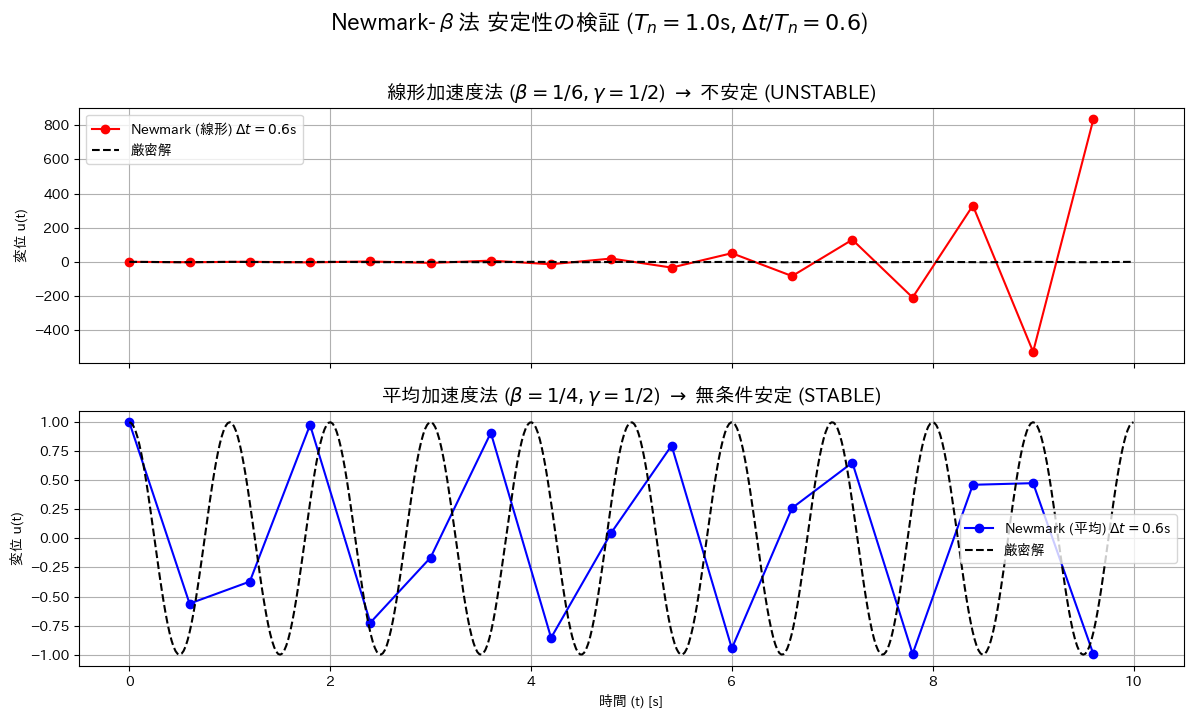

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    """
    Newmark-β法（有効剛性法）の汎用ソルバー

    引数:
    m, c, k : 質量, 減衰, 剛性
    p_force : 外力P(t)の時系列配列
    dt : 時間ステップ Δt
    u0, v0 : 初期変位, 初期速度
    beta, gamma : Newmark-β法のパラメータ

    戻り値:
    t : 時間配列
    u, v, a : 変位, 速度, 加速度の時系列配列
    """

    # ステップ数を計算
    n_steps = len(p_force)

    # 結果を格納する配列を初期化
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    # 初期条件を設定
    u[0] = u0
    v[0] = v0

    # 初期加速度を運動方程式から計算
    if m == 0:
        a[0] = 0
    else:
        a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    # --- Newmark-β法の「有効剛性法」のための係数 ---
    # .docx資料にあった係数
    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    # 有効剛性 K^ (K_hat) を計算
    K_hat = k + a0 * m + a1 * c

    # --- ステップごとの逐次計算ループ ---
    for i in range(n_steps - 1):

        # 有効外力 P^ (P_hat) を計算
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        # (1) u[i+1] を解く
        u[i+1] = P_hat / K_hat

        # (2) a[i+1] を計算
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]

        # (3) v[i+1] を計算
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    # 時間配列を作成
    t = np.arange(0, n_steps * dt, dt)

    return t, u, v, a

# -----------------------------------------------------------------
# 安定性の検証シミュレーション
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- 1. システムのパラメータ設定 ---
    # 固有周期 T_n = 1.0秒 となるように設定
    Tn = 1.0
    wn = 2.0 * np.pi / Tn
    m = 1.0
    k = wn**2 * m
    h = 0.0  # 安定性を見るため減衰ゼロ(h=0)にする
    c = 2.0 * h * wn * m

    # --- 2. 安定限界を超える時間ステップの設定 ---
    # 線形加速度法 (β=1/6) の安定限界は Δt/T_n <= 0.551
    # ここでは、限界を「超える」ように Δt/T_n = 0.6 を設定
    dt = 0.6 * Tn

    # シミュレーション時間
    t_end = 10.0  # 10秒間
    n_steps = int(t_end / dt) + 1

    # 外力 (自由振動なので全てゼロ)
    p_force = np.zeros(n_steps)

    # 初期条件 (t=0で変位1を与えて手を離す)
    u0 = 1.0
    v0 = 0.0

    # --- 3. ケース1: 線形加速度法 (不安定になるはず) ---
    beta_lin = 1.0 / 6.0
    gamma_lin = 1.0 / 2.0
    t1, u1, v1, a1 = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_lin, gamma_lin)

    # --- 4. ケース2: 平均加速度法 (安定なはず) ---
    beta_avg = 1.0 / 4.0
    gamma_avg = 1.0 / 2.0
    t2, u2, v2, a2 = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_avg, gamma_avg)

    # --- 5. 比較用の厳密解 ---
    t_exact = np.linspace(0, t_end, 500)
    u_exact = u0 * np.cos(wn * t_exact) + (v0 / wn) * np.sin(wn * t_exact)

    # --- 6. グラフ描画 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # グラフ1: 線形加速度法
    ax1.plot(t1, u1, 'r-o', label=f'Newmark (線形) $\\Delta t = {dt}$s')
    ax1.plot(t_exact, u_exact, 'k--', label='厳密解')
    ax1.set_title(f'線形加速度法 ($\\beta=1/6, \\gamma=1/2$) $\\to$ 不安定 (UNSTABLE)', fontsize=14)
    ax1.set_ylabel('変位 u(t)')
    ax1.legend()
    ax1.grid(True)

    # グラフ2: 平均加速度法
    ax2.plot(t2, u2, 'b-o', label=f'Newmark (平均) $\\Delta t = {dt}$s')
    ax2.plot(t_exact, u_exact, 'k--', label='厳密解')
    ax2.set_title(f'平均加速度法 ($\\beta=1/4, \\gamma=1/2$) $\\to$ 無条件安定 (STABLE)', fontsize=14)
    ax2.set_xlabel('時間 (t) [s]')
    ax2.set_ylabel('変位 u(t)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(f'Newmark-β法 安定性の検証 ($T_n={Tn}$s, $\\Delta t/T_n = {dt/Tn}$)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()